# Importation des packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

Dataset Shape: (159571, 8)
Columns: Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
Sample Data:
                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0 

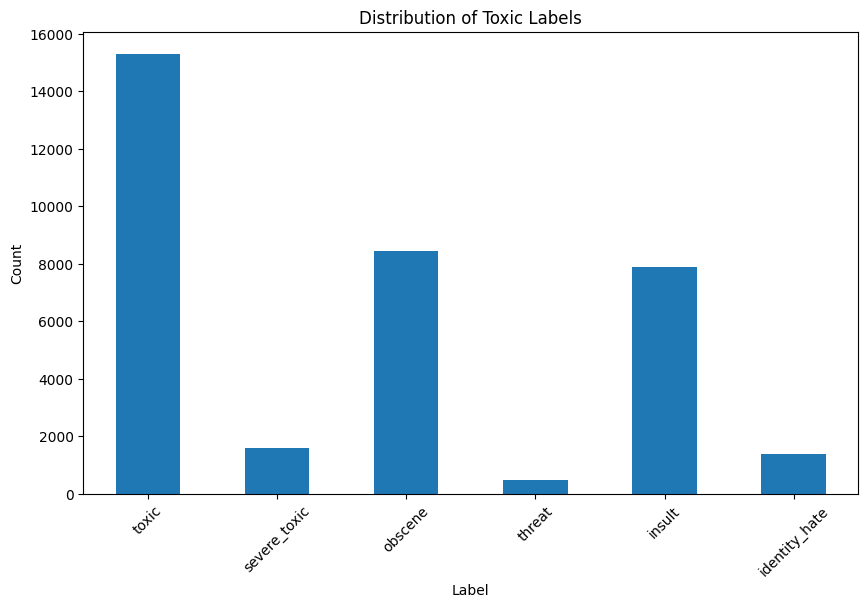

Comment Length Stats:
 count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64


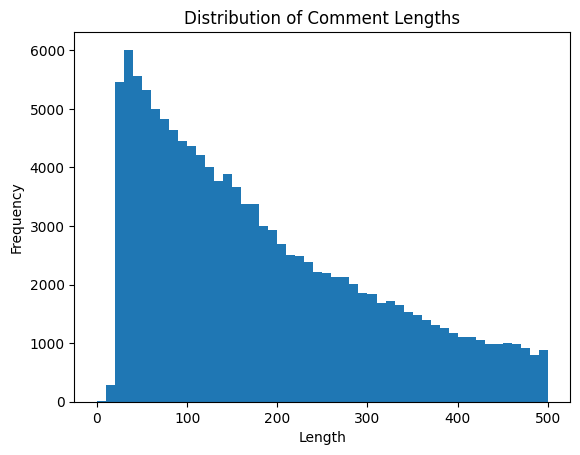

In [5]:
# Your Code
# Etude du jeu de données
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)
print("Sample Data:\n", data.head())

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Label distribution (assuming multi-label columns start from index 2)
labels = data.columns[2:]
label_counts = data[labels].sum()
print("Label Distribution:\n", label_counts)

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title("Distribution of Toxic Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Comment length analysis
data['comment_length'] = data['comment_text'].apply(len)
print("Comment Length Stats:\n", data['comment_length'].describe())
plt.hist(data['comment_length'], bins=50, range=(0, 500))
plt.title("Distribution of Comment Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

# Préparation des données

In [6]:
# Your Code
# Préparation des données
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Use a subset for faster iteration (e.g., 10% of data)
data_subset = data.sample(frac=0.1, random_state=42)

# Basic text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

data_subset['comment_text'] = data_subset['comment_text'].apply(clean_text)

# Tokenization
MAX_WORDS = 5000  # Vocabulary size
MAX_LEN = 100     # Max sequence length
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data_subset['comment_text'])
sequences = tokenizer.texts_to_sequences(data_subset['comment_text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)

# Prepare labels (assuming multi-label)
y = data_subset[labels].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (12765, 100)
y_train Shape: (12765, 6)


# Entraînement du modèle baseline

In [14]:
# Your Code
# Utilisation de 10% des données
data_subset = data.sample(frac=0.1, random_state=42)

# Définir les étiquettes correctes
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Vectorisation TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(data_subset['comment_text'])
y = data_subset[labels].values  # Étiquettes binaires (6 colonnes)

# Séparation train/test
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Vérification des données
print("X_train_tfidf Shape:", X_train_tfidf.shape)
print("y_train Shape:", y_train.shape)
print("Sample of y_train:\n", y_train[:5])

# Modèle baseline
baseline_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
baseline_model.fit(X_train_tfidf, y_train)

# Test du modèle sur des exemples
test_comments = [
    "You’re a disgusting idiot!",
    "Great job, keep it up!",
    "I could kill you for this… just kidding!"
]
print("\nTest du modèle baseline sur des exemples :")
for comment in test_comments:
    X_test_comment = tfidf.transform([comment])
    pred = baseline_model.predict(X_test_comment)[0]
    pred_proba = baseline_model.predict_proba(X_test_comment)[0]
    print(f"\nComment: {comment}")
    print("Prédictions (0/1):", dict(zip(labels, pred)))
    print("Probabilités:", dict(zip(labels, pred_proba)))

# Évaluation avec seuil fixe (0.5)
y_pred = baseline_model.predict(X_test_tfidf)
y_pred_proba = baseline_model.predict_proba(X_test_tfidf)
f1_macro_baseline = f1_score(y_test, y_pred, average='macro')
f1_micro_baseline = f1_score(y_test, y_pred, average='micro')
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba)
print("\nÉvaluation du modèle baseline (seuil fixe 0.5):")
print(f"F1 Score (macro): {f1_macro_baseline:.4f}")
print(f"F1 Score (micro): {f1_micro_baseline:.4f}")
print(f"ROC-AUC Score: {roc_auc_baseline:.4f}")

# Optimisation des seuils
def optimize_thresholds(y_true, y_pred_proba, labels):
    best_thresholds = []
    for i in range(len(labels)):
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1 = 0
        best_thresh = 0.5
        for thresh in thresholds:
            y_pred = (y_pred_proba[:, i] > thresh).astype(int)
            f1 = f1_score(y_true[:, i], y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        best_thresholds.append(best_thresh)
    return best_thresholds

thresholds_baseline = optimize_thresholds(y_test, y_pred_proba, labels)
print("\nSeuils optimisés par étiquette:", dict(zip(labels, thresholds_baseline)))

# Évaluation avec seuils optimisés
y_pred_adjusted = np.zeros_like(y_pred_proba)
for i, thresh in enumerate(thresholds_baseline):
    y_pred_adjusted[:, i] = (y_pred_proba[:, i] > thresh).astype(int)
f1_macro_opt_baseline = f1_score(y_test, y_pred_adjusted, average='macro')
f1_micro_opt_baseline = f1_score(y_test, y_pred_adjusted, average='micro')
print("\nÉvaluation avec seuils optimisés:")
print(f"F1 Score (macro): {f1_macro_opt_baseline:.4f}")
print(f"F1 Score (micro): {f1_micro_opt_baseline:.4f}")

X_train_tfidf Shape: (12765, 5000)
y_train Shape: (12765, 6)
Sample of y_train:
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

Test du modèle baseline sur des exemples :

Comment: You’re a disgusting idiot!
Prédictions (0/1): {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}
Probabilités: {'toxic': 0.961081257391046, 'severe_toxic': 0.022799774602435898, 'obscene': 0.5922669664890221, 'threat': 0.004566872220506237, 'insult': 0.8846498742511492, 'identity_hate': 0.019674049179359703}

Comment: Great job, keep it up!
Prédictions (0/1): {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Probabilités: {'toxic': 0.08032976228819957, 'severe_toxic': 0.01009567537467749, 'obscene': 0.03153510803113403, 'threat': 0.0019796289750069764, 'insult': 0.04361456223950117, 'identity_hate': 0.013496778382502416}

Comment: I could kill you for this… just kidding!
Prédictions (0/1): {'toxic